# Анализ севооборота во Франции

## Устанавливаем необходимые библиотеки


In [1]:
import pandas as pd
import os
import re
from functools import reduce
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import pickle


import geopandas as gpd
from pyproj import Proj
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer

from itertools import product, chain
from sklearn.metrics import accuracy_score

In [2]:
!pip install category_encoders
import category_encoders as ce


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [3]:
!pip install catboost
from catboost import Pool, CatBoostClassifier


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.3 MB/s eta 0:00:00


## Изучение и предобработка данных

Загружаем исходные данные

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/'

train_path = data_path + 'train/'

train_2010_path = data_path + '10-14/2010.csv'
train_2011_path = data_path + '10-14/2011.csv'
train_2012_path = data_path + '10-14/2012.csv'
train_2013_path = data_path + '10-14/2013.csv'
train_2014_path = data_path + '10-14/2014.csv'

codes_10_14_path = data_path + '10-14/'

test_2019_path = data_path + 'test/test 2019/'
test_2020_path = data_path + 'test/test 2020/'



In [6]:
train_2010 = pd.read_csv(train_2010_path)

train_2010.head()

,CULT_MAJ,NUM_ILOT,centroid
0,23,006-600,POINT (1036321.777965606 6313793.803955953)
1,23,006-601,POINT (1062367.545310645 6321180.197514395)
2,23,006-602,POINT (1062424.026822849 6321197.461531096)
3,23,006-603,POINT (1052736.825328681 6313753.632340802)
4,23,006-604,POINT (1052659.154533222 6313747.855598602)


In [7]:
train_2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6123259 entries, 0 to 6123258
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CULT_MAJ  int64 
 1   NUM_ILOT  object
 2   centroid  object
dtypes: int64(1), object(2)
memory usage: 140.2+ MB


In [8]:
test_2019 = pd.read_csv(test_2019_path+'test_2015.csv')

test_2019.head()

,CODE_CULTU,CODE_GROUP,centroid
0,PPH,18,Point (882657.94895066 6569342.10998129)
1,PPH,18,Point (882115.97784605 6572755.67171272)
2,TTH,4,Point (881577.18757373 6569639.00274748)
3,PPH,18,Point (861602.67865301 6594153.2889364)
4,MIS,2,Point (860126.47223916 6591185.82080882)


In [9]:
test_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401645 entries, 0 to 401644
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CODE_CULTU  401645 non-null  object
 1   CODE_GROUP  401645 non-null  int64 
 2   centroid    401645 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


Предобработка данных

In [ ]:
# Функция для объединения таблиц за все годы наблюдений

def get_merged_df_from_csv_files(path):

  files_names = os.listdir(path)
  years = ['2015', '2016', '2017', '2018', '2019', '2020']

  df_list = []
  for i in range(len(files_names)):
    df = pd.read_csv(path+files_names[i])
    columns = df.columns
    df = df.rename(columns={
        columns[0]:columns[0]+'_'+years[i],
        columns[1]:columns[1]+'_'+years[i]
    })
    df_list.append(df)

  merged_df = reduce(lambda left, right: pd.merge(
      left, right, on=['centroid'], how='outer'), df_list)

  return merged_df

In [ ]:
# Функция перевода формата координат центроидов в WGS 84

def get_wgs84_centroid(df):
  df['wgs84_centroid'] = gpd.GeoSeries.from_wkt(
      df['centroid'], crs='epsg:2154').to_crs('epsg:4326')
  return df

Франция - страна с разнообразным ландшафтом и культурными различиями в разных регионах. Добавим в базу данныхь признак с названием региона, чтобы учесть эти различия.

In [ ]:
# Функция добваления признака с названиям региона с использованием внешних данных об административном делении Франции.

regions = gpd.read_file('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/fr_geojson/fr_reg.geojson')[['nom','geometry']]  # Replace with the actual file path

def get_region_name_from_point(point):

  try:
    region = regions.nom[regions.geometry.intersects(point)].values[0]
    return region
  except:
    return 'unknown'

def get_region_names(df):

  df['region'] = df['wgs84_centroid'].apply(get_region_name_from_point)
  return df

Фермер может пользоваться определенной схемой засева своих полей, засевая их из года в год культурами в определенном порядке. Добавим признак символьного обозначения схемы такой последовательности за годы наблюдений.

In [ ]:
# Функция добваления признака с символьным обозначением плана ротации культур.

def get_rotation_plan_from_row(row):
  plan = ''
  plan_values = {}
  plan_value = 'a'
  for el in row:
    if el in plan_values:
      plan += plan_values[el]
    else:
      plan += plan_value
      plan_values[el] = plan_value
      plan_value = chr(ord(plan_value) + 1)
  return plan

def get_rotation_plans(df):
  mask = list(map(lambda column: column.startswith('CODE_GROUP_'), df.columns))
  group_columns = df.columns[mask]
  df['rotation_plan'] = df.apply(
      lambda row: get_rotation_plan_from_row(
          [row[column] for column in group_columns]), axis=1) # df.columns[mask]]

In [ ]:
# Функция добавления признаков широты и долготы из координат центроидов

def get_lat_long(df):
  coords = re.compile('\d+\.\d+')
  df['lat'] = df['wgs84_centroid'].apply(lambda x: coords.findall(str(x))[0])
  df['long'] = df['wgs84_centroid'].apply(lambda x: coords.findall(str(x))[1])
  return df

In [ ]:
# Объединение всех функий предобработки данных

def get_new_features(df):
  get_wgs84_centroid(df)
  get_region_names(df)
  get_rotation_plans(df)
  get_lat_long(df)
  return df

Сериализуем функцию предобработки данных

In [ ]:
cd '/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output'

/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output


In [ ]:
with open('pickle/get_new_features.pkl', 'wb') as output:
 pickle.dump(get_new_features, output)

In [ ]:
with open('pickle/get_new_features.pkl', 'rb') as output:
 get_new_features = pickle.load(output)

Объеденим базы данных за все годы наблюдений.

In [ ]:
train = get_merged_df_from_csv_files(train_path)
test_2019 = get_merged_df_from_csv_files(test_2019_path)

Добавим новые признаки.

In [ ]:
train = get_new_features(train)
test_2019_df = get_new_features(test_2019)

Отделим вектор классов от тренировочной базы данных.

In [ ]:
train_df = train.drop(columns=['CODE_CULTU_2019', 'CODE_GROUP_2019'])
y_train = train[['CODE_CULTU_2019', 'CODE_GROUP_2019']]

Сохраним обработанные данных в файлы.

In [ ]:
train_df.to_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/train_df', index=False)
y_train.to_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/y_train', index=False)
test_2019_df.to_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/test_2019_df', index=False)

Почитаем данные из файлов.

In [10]:
train_df = pd.read_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/train_df')
y_train = pd.read_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/y_train')[['CODE_CULTU_2019']]
test_2019_df = pd.read_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/test_2019_df')

In [11]:
train_df = train_df.drop(columns=['centroid', 'wgs84_centroid'])
test_2019_df = test_2019_df.drop(columns=['centroid', 'wgs84_centroid'])

In [12]:
train_df.head()

,CODE_CULTU_2015,CODE_GROUP_2015,CODE_CULTU_2016,CODE_GROUP_2016,CODE_CULTU_2017,CODE_GROUP_2017,CODE_CULTU_2018,CODE_GROUP_2018,region,rotation_plan,lat,long
0,PPH,18,PPH,18,PPH,18,PPH,18,Auvergne-Rhône-Alpes,aaaaa,5.687835,46.059652
1,PPH,18,PPH,18,PPH,18,PPH,18,Auvergne-Rhône-Alpes,aaaaa,5.675419,46.023028
2,PPH,18,PPH,18,PPH,18,PPH,18,Auvergne-Rhône-Alpes,aaaaa,5.669532,46.032552
3,PPH,18,PPH,18,PPH,18,PPH,18,Auvergne-Rhône-Alpes,aaaaa,5.670588,46.035836
4,PPH,18,PPH,18,PPH,18,PPH,18,Auvergne-Rhône-Alpes,aaaaa,5.671097,46.023685


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614804 entries, 0 to 3614803
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   CODE_CULTU_2015  object 
 1   CODE_GROUP_2015  int64  
 2   CODE_CULTU_2016  object 
 3   CODE_GROUP_2016  int64  
 4   CODE_CULTU_2017  object 
 5   CODE_GROUP_2017  int64  
 6   CODE_CULTU_2018  object 
 7   CODE_GROUP_2018  int64  
 8   region           object 
 9   rotation_plan    object 
 10  lat              float64
 11  long             float64
dtypes: float64(2), int64(4), object(6)
memory usage: 330.9+ MB


In [ ]:
# train_df = train_df.drop(columns=['centroid', 'wgs84_centroid'])
# test_2019_df = test_2019_df.drop(columns=['centroid', 'wgs84_centroid'])

In [ ]:
cultu_columns = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
           'CODE_CULTU_2018', 'region', 'rotation_plan', 'lat', 'long']

group_columns = ['CODE_GROUP_2015', 'CODE_GROUP_2016', 'CODE_GROUP_2017',
           'CODE_GROUP_2018', 'region', 'rotation_plan', 'lat', 'long']

Выделим случайную часть тренировочного датасета для обучения на нем модели, удалим данные с классами, которые встречаются менее четырех раз.

In [ ]:
y_train['CODE_CULTU_2019'].value_counts(ascending=True)

BUR          1
CNE          1
PSY          1
JOS          1
VER          1
        ...   
PRL     179061
VRC     186564
PTR     189120
BTH     347876
PPH    1186465
Name: CODE_CULTU_2019, Length: 226, dtype: int64

In [14]:
sample_coef = 0.01

sample_shape = round(train_df.shape[0]*sample_coef)
sample = random.sample(range(train_df.shape[0]), sample_shape)

y_train_sample = y_train.iloc[sample]

In [50]:
y_train_sample.shape[0]

36148

In [15]:
# Найдем классы, которые встречаются менее 4-х раз
rows_to_drop = y_train_sample['CODE_CULTU_2019'].value_counts(ascending=True)
index_to_drop = rows_to_drop[rows_to_drop.values<4].index.values.tolist()

# Удалим эти записи
for index in index_to_drop:
  y_train_sample = y_train_sample[y_train_sample['CODE_CULTU_2019'] != index]

# Выделим соответствующие записи
train_df_sample = train_df.iloc[y_train_sample.index]

## Обучение модели на полученных данных.

Прежде, чем обучать модель, предположим, что фермер высаживает из года в год одну и ту же культуру. Проверим точность такого предсказания.

In [16]:
print('Accuracy score: ', accuracy_score(y_train, train_df['CODE_CULTU_2018']))

Accuracy score:  0.7000855371411562


Разделение выборок на обучающую и валидационную.

In [17]:
# X_train, X_val, Y_train, Y_val = train_test_split(train_df.iloc[sample], y_train.iloc[sample], test_size=0.2, random_state=14, stratify=y_train.iloc[sample])
X_train, X_val, Y_train, Y_val = train_test_split(train_df_sample, y_train_sample['CODE_CULTU_2019'], test_size=0.5, random_state=14, stratify=y_train_sample['CODE_CULTU_2019'])

#Список категориальных переменных для модели
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Найдем оптимальные параметры модели.

In [18]:
grid = {
    'depth':[7, 9, 11],
    # 'iterations':[100,200,500],
    'learning_rate':[0.05,0.1,0.2, 0.4],
    'l2_leaf_reg':[5,10,15,20]
    }


In [19]:
model = CatBoostClassifier(
    loss_function='MultiClass',

    # # depth=5,
    iterations=500,
    # learning_rate=0.01,
    # l2_leaf_reg=10,

    task_type='GPU',
    cat_features=cat_features,
    # class_names=list(train_class_names),
    logging_level='Silent'
)

In [ ]:
#RandomizedSearchCV

# Создаем объект решетчатого поиска
rgs = RandomizedSearchCV(
    estimator=model,
    param_distributions=grid,
    cv=2,
    scoring=make_scorer(accuracy_score),
    verbose=0)

# Обучаем модель с использованием решетчатого поиска
rgs.fit(X_train, Y_train)

# Получаем результаты решетчатого поиска
results = rgs.cv_results_
params = results['params']
mean_test_score = results['mean_test_score']



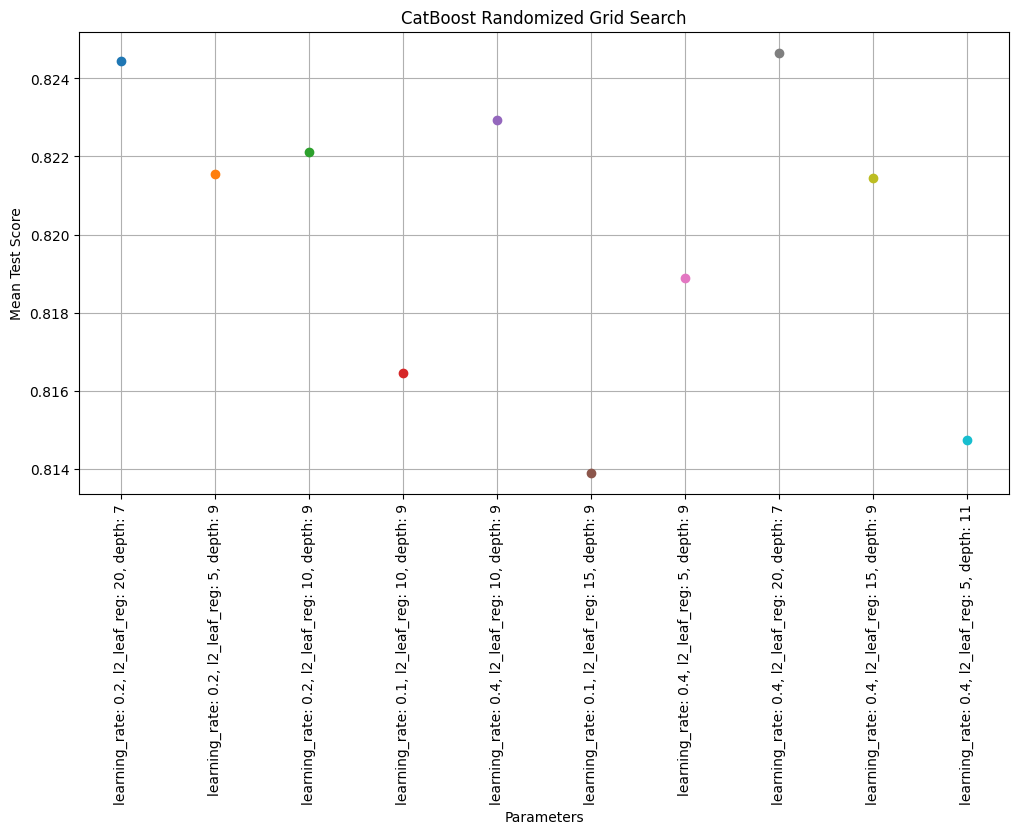

In [ ]:
# Выводим график зависимости значения метрики качества от параметров
plt.figure(figsize=(12, 6))
for i in range(len(params)):
    param_name = ', '.join([f'{key}: {value}' for key, value in params[i].items()])
    plt.plot(param_name, mean_test_score[i], marker='o')
plt.xlabel('Parameters')
plt.ylabel('Mean Test Score')
plt.title('CatBoost Randomized Grid Search')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [20]:
best_params = {
    'depth': 7,
    'l2_leaf_reg': 20,
    'learning_rate': 0.2
    }

Обучим модель с полученными параметрами.

In [21]:
train_dataset = Pool(data=X_train,
                     label=Y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_val,
                    label=Y_val,
                    cat_features=cat_features)

model = CatBoostClassifier(
    loss_function='MultiClass',
    task_type='GPU',
    depth=7,
    l2_leaf_reg=20,
    iterations=1000,
    learning_rate=0.4,
    verbose=0
    )

#Обучение модели
model.fit(train_dataset)
#Получение предсказаний
preds_class = model.predict(eval_dataset)

print('Accuracy score: ', accuracy_score(Y_val,preds_class))

Accuracy score:  0.8465461802860628


Определим важность признаков.

In [22]:
columns = X_train.columns
importances = model.feature_importances_

In [23]:
features_importances = pd.DataFrame({
    'columns':columns,
    'importances':importances}).sort_values(by='importances', ascending = False)

features_importances

,columns,importances
7,CODE_GROUP_2018,80.386042
6,CODE_CULTU_2018,11.438692
9,rotation_plan,1.970512
11,long,1.173405
5,CODE_GROUP_2017,1.132266
10,lat,1.098532
2,CODE_CULTU_2016,0.715085
3,CODE_GROUP_2016,0.670577
1,CODE_GROUP_2015,0.666570
4,CODE_CULTU_2017,0.396981


Самым важным признаком стал признак группы культур в последнем году.

Сериализуем модель.

In [25]:
with open('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/pickle/model.pkl', 'wb') as output:
 pickle.dump(model, output)

In [26]:
with open('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/pickle/model.pkl', 'rb') as output:
 model = pickle.load(output)

In [27]:
X_val['CODE_CULTU_2019_pred'] = preds_class

In [28]:
prediction_2019 = X_val['CODE_CULTU_2019_pred']

Предположим, что фермеры засеивают поля знакомыми для себя культурами и не пользуются новыми. Заменим предсказание модели на культуру, которая засеивалась в предыдущем году.

In [29]:
mask = (
  (X_val['CODE_CULTU_2019_pred'] != X_val['CODE_CULTU_2015']) &
  (X_val['CODE_CULTU_2019_pred'] != X_val['CODE_CULTU_2016']) &
  (X_val['CODE_CULTU_2019_pred'] != X_val['CODE_CULTU_2017']) &
  (X_val['CODE_CULTU_2019_pred'] != X_val['CODE_CULTU_2018'])
)


In [30]:
X_val.loc[mask, 'CODE_CULTU_2019_pred'] = X_val.loc[mask, 'CODE_CULTU_2018']
preds_class_replaced = X_val['CODE_CULTU_2019_pred']

Сравним результаты.

In [31]:
print('Accuracy score: ', accuracy_score(Y_val,preds_class_replaced))

Accuracy score:  0.8268100676349928


Результат предсказаний оказался оказался хуже более чем на 2 процента, возвращаемся к предсказаниям модели.

In [59]:
X_val['CODE_CULTU_2019_pred'] = preds_class

Сделаем предсказание по данным 2016-2019 года на 2020 год.

In [32]:
# test_2020_df = get_merged_df_from_csv_files(test_2020_path)
# test_2020_df = test_2020_df.drop(columns=['CODE_CULTU_2015', 'CODE_GROUP_2015'])
# test_2020_df = get_new_features(test_2020_df)
# test_2020_df = test_2020_df.drop(columns=['centroid', 'wgs84_centroid'])
# test_2020_df.to_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/test_2020_df', index=False)
test_2020_df = pd.read_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/test_2020_df')



Переименуем соответвующие признаки.

In [33]:
test_2020_df = test_2020_df.rename(columns={
    'CODE_CULTU_2016': 'CODE_CULTU_2015',
    'CODE_CULTU_2017': 'CODE_CULTU_2016',
    'CODE_CULTU_2018': 'CODE_CULTU_2017',
    'CODE_CULTU_2019': 'CODE_CULTU_2018',
    'CODE_GROUP_2016': 'CODE_GROUP_2015',
    'CODE_GROUP_2017': 'CODE_GROUP_2016',
    'CODE_GROUP_2018': 'CODE_GROUP_2017',
    'CODE_GROUP_2019': 'CODE_GROUP_2018',
})

In [34]:
test_2020_df['CODE_CULTU-2020_pred'] = model.predict(test_2020_df)

In [35]:
prediction_2020 = test_2020_df['CODE_CULTU-2020_pred']

Сохраним результаты предсказаний на 2019 и 2020 год.

In [36]:
prediction_2019.to_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/prediction_2019', index=False)
prediction_2020.to_csv('/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/data/output/prediction_2020', index=False)

Сохраним в файл все установленные и необходимые для работы приложения.

In [37]:
pip freeze > '/content/drive/MyDrive/SkillFactory/CropRotationAnalysis/requirements.txt'


## Вывод

В результате исследования данных, выявления последовательности смены посевных культур на заданных полях была получена модель машинного обучения, которая прогнозирует культуру
посева на указанный год с точностью 95%.